# Question: "Is the statement “drive for show” quantifiably true in the era of social networks?"



## 2. Data and Exploratory Data Analysis

### 2.1 Data

We created a dataset containing the driving distance, the number of year-to-date victories, the age, the earning, and the year of turning professional of the top 150 PGA players on the 2021 official money ranking (as of April 12) from the official PGA TOUR website (https://www.pgatour.com/stats/stat.109.html). Then, we manually complie a column of each player's instagram username. Since we excluded all the players without instgram account, the final data set consisting the data of 141 PGA players. Then, we scrappred the number of instagram followers of each player uisng the packgage `instascrape`. We also created a binary variable `isLongHitter`,  which indicates whether the player drives longer than the average driving distance on PGA TOUR (295.6 yards). 

In [1]:
# Importign packages
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [2]:
# Importing 2021 Money List Data 
money_list21 = pd.read_csv('PGAMoneyList21.csv') 

In [3]:
#Drop NaNs
money_list21 = money_list21.dropna(subset=['IG Username'])
money_list21.dtypes

# Dropping the "$" in column 'Money' and convert the column's type to float
# ref: https://pbpython.com/currency-cleanup.html
def money_to_float(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

money_list21['Money'] = money_list21['Money'].apply(money_to_float).astype('float')
money_list21['isLongHitter'] = np.where(money_list21['Driving Distance'] > 295.6 , 'Yes', 'No')

In [4]:
# Solve Instagram Login Indirect Error

#ref: http://valvepress.com/how-to-get-instagram-session-cookie/
#ref: https://github.com/chris-greening/instascrape/discussions/70
headers = {
    "user-agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Mobile Safari/537.36 Edg/87.0.664.57",
    "cookie": "sessionid= 511722277%3APEX9yKTWbTvp39%3A18;"
}

In [5]:
# Scrape number of IG followers of each PGA player 
from instascrape import *

followers = []
for user in money_list21['IG Username']:
    prof = Profile(user)
    prof.scrape(headers=headers)
    x = prof.followers
    followers.append(x)

money_list21['Followers'] = followers

In [6]:
money_list21.head()

,Ranking,Name,IG Username,Money,YTD Victory,Age,Year (Turned Pro),Driving Distance,isLongHitter,Followers
0,1,Justin Thomas,justinthomas34,5539361.0,1,27,2013,301.7,Yes,1163808
1,2,Bryson DeChambeau,brysondechambeau,5443091.0,2,27,2016,321.1,Yes,644759
2,3,Xander Schauffele,xanderschauffele,4203501.0,0,27,2015,306.0,Yes,148008
3,4,Hideki Matsuyama,hidekimatsuyama1,3741419.0,1,29,2013,296.8,Yes,66510
4,5,Jordan Spieth,jordanspieth,3691056.0,1,27,2012,297.2,Yes,1581216


### 2.2  Data Preparation and Exploratory Data Analysis

Text(0.5, 0.98, 'Distribution of Number of Instagram Followers')

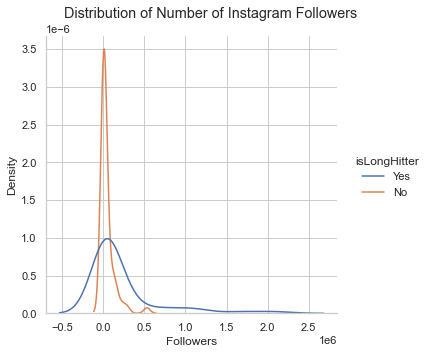

In [7]:
fig1 = sns.displot(money_list21, x= "Followers", kind="kde", hue = "isLongHitter")
fig1.fig.subplots_adjust(top=0.9) 
fig1.fig.suptitle('Distribution of Number of Instagram Followers')

Since the plot above suggests that the distribution of number of instagram followers for both *long* and *short* hitters are right skewed, we decided to perform a log-transformation on `Followers`. 

Text(0.5, 0.98, 'Distributions of Number of Followers (on log-scale)')

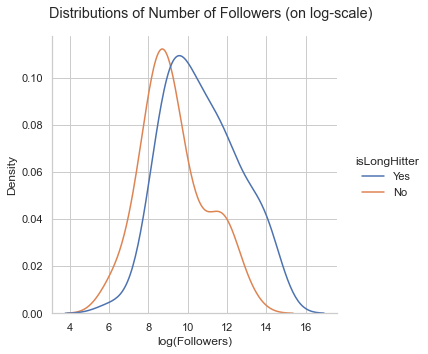

In [8]:
# Log Transformation
money_list21['log(Followers)'] = np.log(money_list21['Followers'] )

fig2 = sns.displot(money_list21, x= "log(Followers)", kind="kde", hue = "isLongHitter")
fig2.fig.subplots_adjust(top=0.9) 
fig2.fig.suptitle('Distributions of Number of Followers (on log-scale)')

With a log-transformation on `Followers`, the distribution of number of followers of both groups seem to be more normally distributed. Based on the plot above, it appears that the mean number of instagram followers of players who drive longer than the PGA average driving distance (295.6 yards) is *higher* than the mean number of followers of  players who drive shorter than the average.

Text(0.5, 0.98, 'Average Driving Distance VS. Number of Followers on Instagram (Log-Transformation)')

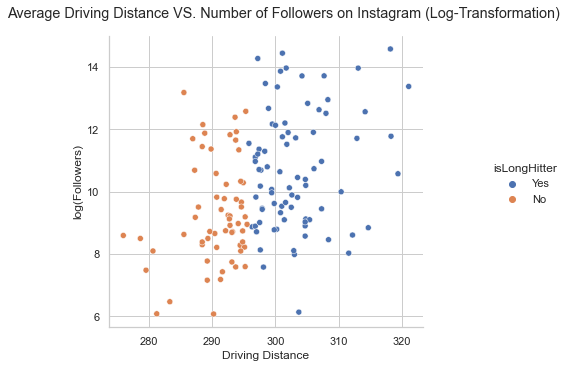

In [9]:
fig3 = sns.relplot(data= money_list21, x="Driving Distance", y="log(Followers)", hue = "isLongHitter", height=5)
fig3.fig.subplots_adjust(top=0.9) 
fig3.fig.suptitle('Average Driving Distance VS. Number of Followers on Instagram (Log-Transformation)')

This scatter plot shows that a positive relationship between the driving distance and the number of instagram followers of each PGA player. It also suggests that the long hitters seems to have more instgram followers that the short hitters. 

## One-Sided Two Sample T-test

In order to answer the question, "*Is the statement “drive for show” quantifiably true in the era of social networks?*". 

We conducted a (one-sided) hypothesis test using the t-distribution under the following hypotheses: 

Null hypothesis ($H_0$) : $\mu_{short} = \mu_{long}$


Alternative hypothesis ($H_A$) : $\mu_{short} < \mu_{long}$

In [10]:
from scipy import stats
from scipy.stats import t


short_hitter = money_list21[money_list21["isLongHitter"] == "No"]["log(Followers)"]
long_hitter = money_list21[money_list21["isLongHitter"] == "Yes"]["log(Followers)"]

df = len(short_hitter) + len(long_hitter) - 2

t_test = stats.ttest_ind(short_hitter,long_hitter, equal_var = False)

real_t_score = t_test.statistic
real_pvalue = t_test.pvalue/2

print("t-score: ",real_t_score, 
     "P-value: ", real_pvalue)

t-score:  -4.709982676409185 P-value:  3.0163905836281853e-06


After conducting the test, we get the p-value of 0.000003. Since our p-value is less than our significance value of 0.05, we reject the null hypothesis that the mean number of instagram followers of two groups are equal. The data provides sufficient evidence to support the claim that long hitters tend to have more instagram followers than the short hitters. 